# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
rmse -корень среднеквадратичного отклонения

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.


https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/data


**Построение модели регресси**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Подбор моделей, получение бейзлана
7. Проверка качества, борьба с переобучением
8. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

**Подключение библиотек и скриптов**



In [77]:
# 1. Базовые библиотеки
import numpy as np
import pandas as pd
from scipy import stats
import pickle   # для сохранения модели

import matplotlib
from matplotlib import pyplot as plot
import seaborn
%matplotlib inline

from datetime import datetime

# 2. Разделение набора данных
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 4. Качественные метрики
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Визуализация изображений
from IPython.display import Image

**Settings**


In [78]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plot.style.use('seaborn')
plot.rcParams.update({'font.size': 14}) 

import warnings
warnings.filterwarnings('ignore')

**Пути к директориям и файлам**

In [79]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'

SAMPLE_SUBMISSION = 'data/sample_submission.csv'
FINAL_SUBMISSION = 'data/khorev_predictions.csv'

PREPARED_TRAIN_DATASET_PATH = 'data/train_prepared.csv'
PREPARED_TEST_DATASET_PATH = 'data/test_prepared.csv'

MODEL_FILE_PATH = 'model.pkl'

**Уменьшение объема памяти, занимаемой функцией набора данных**

In [80]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Оценочные функции**

In [81]:
def evaluate_preds(true_values, pred_values, save=False):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plot.figure(figsize=(13, 5))
    
    seaborn.scatterplot(x=pred_values, y=true_values)
    plot.plot([0, 500000], [0, 500000], linestyle='--', color='black') 
    
    plot.xlabel('Predicted values')
    plot.ylabel('True values')
    plot.title('True vs Predicted values')
    
    if save == True:
        plot.savefig(REPORTS_FILE_PATH + 'report.png')
    plot.show()

**Загрузка данных**

 **Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [82]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [83]:
train_df.shape

(10000, 20)

In [84]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [85]:
train_df.rename(columns = {'Helthcare_2' : 'Healthcare_2'}, inplace=True)

In [86]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Healthcare_2   10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [87]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [88]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [89]:
test_df.shape

(5000, 19)

In [90]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [91]:
test_df.rename(columns = {'Helthcare_2' : 'Healthcare_2'}, inplace=True)

In [92]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Healthcare_2   5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [93]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


**Приведение типов**

In [94]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Healthcare_2       int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

**Обзор шкал переменных**

In [95]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features.drop('Id', axis=1, inplace=True)
df_num_features.drop('DistrictId', axis=1, inplace=True)
df_num_features.drop('Price', axis=1, inplace=True)
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1
0,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1
3,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6


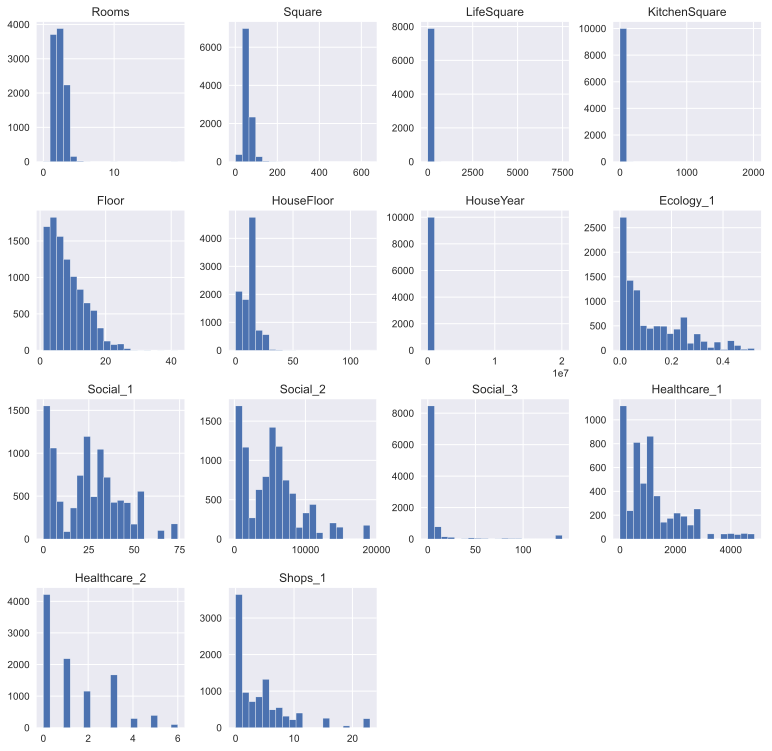

In [96]:
df_num_features.hist(figsize=(13, 13), bins=20, grid=True)
plot.subplots_adjust(hspace=0.35)
plot.show()

In [97]:
df_object_type = train_df.select_dtypes(include='object')
df_object_type.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


**Распределение целевой переменной**

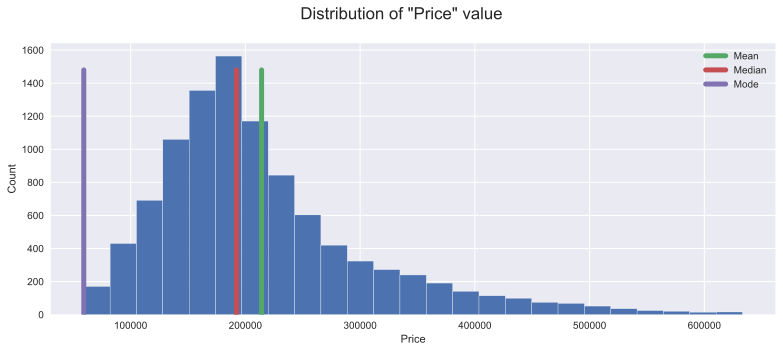

In [98]:
plot.figure(figsize=(13, 5))

train_df['Price'].hist(density=False, bins=25)
plot.ylabel('Count')
plot.xlabel('Price')
plot.suptitle('Distribution of "Price" value')

target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

y = np.linspace(0, 1480, 10)
plot.plot([target_mean] * 10, y, label='Mean',  linewidth=5)
plot.plot([target_median] * 10, y, label='Median',  linewidth=5)
plot.plot([target_mode] * 10, y, label='Mode', linewidth=5)

plot.legend()
plot.show()

**Обработка данных**

Создание класса обработки данных

In [99]:
class Data:
    
    def __init__(self):
        """Константы для обработки выбросов на основе анализа данных"""
        self.square_min_value = 35
        self.square_max_value = 90
        
        self.life_square_min_value = 20
        self.life_square_max_value = 65
        
        self.kitchen_square_min_value = 5
        self.kitchen_square_max_value = 10
        
        self.housefloor_min_value = 1
        self.housefloor_max_value = 50
        
        self.current_year = datetime.now().year
        
        self.medians = None
        self.AverageSquareMeterPrice = None
        self.MedPriceByDistrict = None
        
    def fit(self, train_df):
        
        # Медианные значения
        self.medians = train_df.median()

        # Расчет медианной цены квадратного метра по площади
        train_df_temp = train_df.loc[((train_df['Square'] > self.square_min_value) & (train_df['Square'] < self.square_max_value))]
        train_df_temp["SquareMeterPrice"] = train_df_temp["Price"] / train_df_temp["Square"]
        self.AverageSquareMeterPrice = train_df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'median'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        del train_df_temp
        
        # Расчет медианной цены по районам
        self.MedPriceByDistrict = train_df.groupby(['DistrictId', 'Rooms'], as_index=False)\
        .agg({'Price':'median'})\
        .rename(columns={'Price':'MedPriceByDistrict'})
        
        
    def transform(self, df):
        
        # Обработка пробелов
        
        # Заполнение пропусков средним значением LifeSquare
        df['LifeSquare'] = df['LifeSquare'].fillna(self.medians.LifeSquare)
        
        # Заполнение пропусков средним значением Healthcare_1.
        df['Healthcare_1'] = df['Healthcare_1'].fillna(self.medians.Healthcare_1)
        
        # Обработка выбросов
        
        # Обработка Rooms
        # Заполнение выбросов средним значением
        df.loc[df['Rooms'] == 0, 'Rooms'] = self.medians.Rooms
        df.loc[df['Rooms'] >= 10, 'Rooms'] = self.medians.Rooms
        
        # Обработка Square
        # If LifeSquare > Square: exchange values
        square_condition = df['Square'] < df['LifeSquare']
        df.loc[square_condition, 'Square'] = df.loc[square_condition, 'LifeSquare']
        
        # Заполнение выбросов средним значением
        square_condition = (df['Square'] < self.square_min_value) | (df['Square'] > self.square_max_value)
        df.loc[square_condition, 'Square'] = self.medians.Square
        
        # Обработка LifeSquare
        # Заполнение выбросов средним значением
        lifesquare_condition = (df['LifeSquare'] < self.life_square_min_value) | (df['LifeSquare'] > self.life_square_max_value)
        df.loc[lifesquare_condition, 'LifeSquare'] = self.medians.LifeSquare
        
        # Обработка KitchenSquare
        # Заполнение выбросов средним значением
        kitchensquare_condition = (df['KitchenSquare'] < self.kitchen_square_min_value) | (df['KitchenSquare'] > self.kitchen_square_max_value)
        df.loc[kitchensquare_condition, 'KitchenSquare'] = self.medians.KitchenSquare
        
        # Проверка Square
        # If Square < LifeSquare + KitchenSquare: Square = LifeSquare + KitchenSquare + ( LifeSquare + KitchenSquare) * 10%
        square_condition = (df['Square'] < (df['LifeSquare'] + df['KitchenSquare']))
        df.loc[square_condition, 'Square'] = df.loc[square_condition, 'LifeSquare'] + df.loc[square_condition, 'KitchenSquare'] + ((df.loc[square_condition, 'LifeSquare'] + df.loc[square_condition, 'KitchenSquare'] * 0.1))
        
        # Обработка Floor and HouseFloor
        # If HouseFloor < Floor: exchange values
        house_floor_condition = df['HouseFloor'] < df['Floor']
        df.loc[house_floor_condition, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']
        
        # Заполнение выбросов средним значением
        house_floor_condition = (df['HouseFloor'] < self.housefloor_min_value) | (df['HouseFloor'] > self.housefloor_max_value)
        df.loc[square_condition, 'HouseFloor'] = self.medians.HouseFloor
        
        # Обработка HouseYear
        # If HouseYear > current year set median value
        condition_year = (df['HouseYear'] >= self.current_year)
        df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear

        # Обработка Ecology and Shops
        # Switch to binary
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        return df
    
    def features(self, df):
         
        # Добавление медианной цены за квадратный метр по площади
        df = df.merge(self.AverageSquareMeterPrice, on=["DistrictId"], how='left')
        df['AverageSquareMeterPrice'].fillna(df['AverageSquareMeterPrice'].median(), inplace=True)
        
        # Добавление медианной цены по районам
        df = df.merge(self.MedPriceByDistrict, on=['DistrictId', 'Rooms'], how='left')
        df['MedPriceByDistrict'].fillna(df['MedPriceByDistrict'].median(), inplace=True)
        
        return df

**Инициализация класса данных**

In [100]:
data_inst = Data()

# Training data
data_inst.fit(train_df)
train_df = data_inst.transform(train_df)
train_df = data_inst.features(train_df)

# Validation data
test_df = data_inst.transform(test_df)
test_df = data_inst.features(test_df)

In [101]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       5000 non-null   int64  
 1   DistrictId               5000 non-null   int64  
 2   Rooms                    5000 non-null   float64
 3   Square                   5000 non-null   float64
 4   LifeSquare               5000 non-null   float64
 5   KitchenSquare            5000 non-null   float64
 6   Floor                    5000 non-null   int64  
 7   HouseFloor               5000 non-null   float64
 8   HouseYear                5000 non-null   int64  
 9   Ecology_1                5000 non-null   float64
 10  Ecology_2                5000 non-null   int64  
 11  Ecology_3                5000 non-null   int64  
 12  Social_1                 5000 non-null   int64  
 13  Social_2                 5000 non-null   int64  
 14  Social_3                

**Корреляционная матрица**

Показывает линейную зависимость между переменными \ Изменяется от -1 до 1 \ Корреляция - мера только линейной зависимости

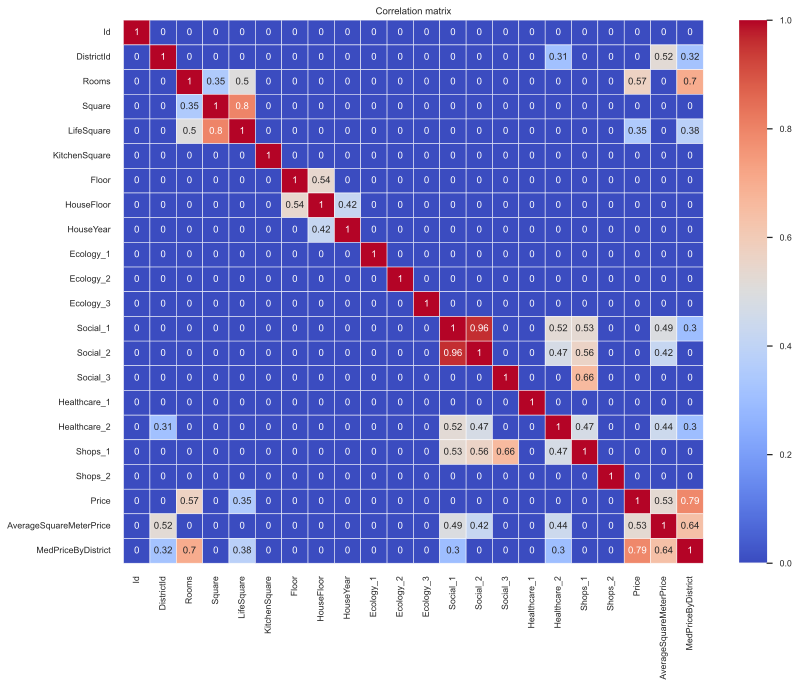

In [102]:
plot.figure(figsize=(13, 10))

seaborn.set(font_scale=0.8)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

seaborn.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')

plot.title('Correlation matrix')
plot.show()

**Уменьшение объема памяти, занимаемой набором данных**

In [103]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.75 MB
Memory usage after optimization is: 0.62 MB
Decreased by 64.7%


In [104]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.84 MB
Memory usage after optimization is: 0.29 MB
Decreased by 65.3%


**Выбор функций**

In [105]:
test_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Healthcare_2',
 'Shops_1',
 'Shops_2',
 'AverageSquareMeterPrice',
 'MedPriceByDistrict']

In [106]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Healthcare_2',
 'Shops_1',
 'Shops_2',
 'AverageSquareMeterPrice',
 'MedPriceByDistrict']

target_name = 'Price'

**Split into train and test**

In [107]:
train_df = train_df[feature_names + [target_name]]
test_df = test_df[feature_names]

X = train_df[feature_names]
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

**Модель деревьев решений с градиентным усилением**

In [108]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=42)

R2:	0.861
RMSE:	34126.05
MSE:	1164587259.591


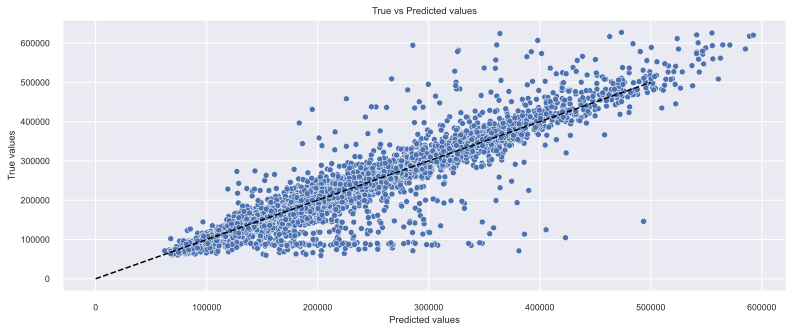

In [109]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.742
RMSE:	48700.049
MSE:	2371694776.839


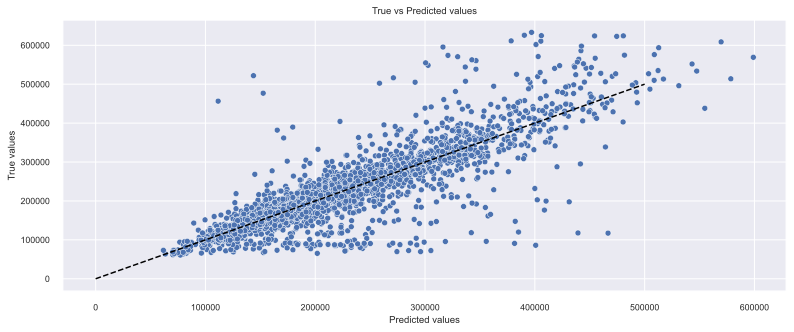

In [110]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

**Предсказание тестового набора данных**

In [111]:
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,AverageSquareMeterPrice,MedPriceByDistrict
0,44,1.0,71.062523,32.781261,5.0,5,13.0,1970,0.036122,1,1,24,4378,0,1036.0,1,1,1,4626.291016,171145.171875
1,62,1.0,96.136269,42.568134,10.0,7,13.0,2017,0.072158,1,1,2,629,1,900.0,0,0,0,2667.264160,129107.218750
2,27,2.0,59.463676,32.781261,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,900.0,0,1,1,2759.086426,165683.078125
3,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,1,1,2,475,0,900.0,0,0,1,2342.651367,166687.734375
4,74,1.0,53.837055,32.781261,6.0,8,17.0,1977,0.309479,1,1,35,7715,4,990.0,0,6,1,3333.668945,165071.828125


In [115]:
submit = pd.read_csv(SAMPLE_SUBMISSION)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [116]:
predictions = gb_model.predict(test_df)
predictions

array([153754.81969334, 119555.73987495, 132398.97936147, ...,
       145450.92315064, 183256.59941701, 282161.77354058])

In [117]:
submit ['Price'] = predictions
submit.head()

,Id,Price
0,4567,153754.819693
1,5925,119555.739875
2,960,132398.979361
3,3848,141785.701006
4,746,157130.656981


In [118]:
submit.shape

(5000, 2)

**Сохранение и проверка**

In [119]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(gb_model, file)

In [120]:
with open(MODEL_FILE_PATH, 'rb') as file:
    final_model = pickle.load(file)
    
final_model

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=42)

In [121]:
submit.to_csv(FINAL_SUBMISSION, index=False, sep=",")

In [122]:
train_df.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, sep=",")

In [123]:
test_df.to_csv(PREPARED_TEST_DATASET_PATH, index=False, sep=",")

In [124]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
